In [1]:
import numpy as np
import random
import scipy.stats

Things to try: 
self-unknown?
input cliques, instead of just pairs
distances between voters?
directed pairs of neighbors? e.g. celebrities
different local allocation rules (as keywords in allocate function)
different graphs, sparsities

In [2]:
# each voter is an index in the array

def construct_neighbors(truecompetencies, neighborpairs):
    """Returns direct neighbors of voters given pairs of neighbors (edges in graph)
    ARGS:
        truecompetencies: list of true competencies (between 0 and 1) for each voter
        neighborpairs: list of unrepeated, undirected pairs of neighbors; not necessarily ordered
    
    OUTPUTS:
        neighbors: list of direct neighbors for each voter
    """
    n = len(truecompetencies)
    
    if np.sum(np.array(neighborpairs).flatten() > n - 1) != 0:
        return("Error: Pair contains nonexistent voter.")
    
    # initialize neighborlist
    neighbors = [[] for i in range(n)]
    
    # add neighbors
    for pair in neighborpairs:
        (p1, p2) = pair
        neighbors[p1].append(p2)
        neighbors[p2].append(p1)

    return neighbors

In [3]:
# perceived competencies are just based on public voting record. extend to voting for representative?
# unless we want to consider if stop watching -- if i vote right i don't look at others?
def prior_competencies(competencies):
    """Initializes Beta(1,1) public competency distribution priors for everyone
    ARGS:
        competencies: list of true competencies (between 0 and 1) for each voter
    OUTPUTS:
        priors: list of Beta parameters for each individual
    """
    n = len(competencies)
    priors = [(1,1) for i in range(n)] # initialize everyone to Beta(1,1)=Unif(0,1) distributions
    return priors

In [66]:
def allocate(truecompetencies, pubcompetencies, neighbors, mechanism="standard"):
    """Returns index of final voter whom each voter allocates their vote to
    ARGS:
        truecompetencies: list of true competencies (between 0 and 1) for each voter
        pubcompetencies: list of public competency distributions for each voter, as paramters for Beta dist
        neighbors: list of direct neighbors for each voter
    Options:
        mechanism: local delegation mechanism to use (see below)
    Mechanisms:
        "standard": each voter delegates to their neighbor with highest mean competency (if they exist).
                    in case of ties, voter delegates to the first in their list
        "truestandard": each voter delegates to their neighbor with highest true competency (if they exist).
                    in case of ties, voter delegates to the first in their list
        "probstandard": each voter delegates to their neighbor with highest mean competency  (if they exist) with the probability they are actually better.
                    in case of ties, voter delegates to the first in their list
        "weightedprob": each voter randomly delegates to a more competent neighbor (if they exist), weighted by their perceived probability of being better
        "direct": no allocation
                    
        TODO: other (non-deterministic) mechanisms?
    
    OUTPUTS:
        allocation: list of indices, where each value is the index of the sink
                    voter whom that voter delegates to
    """
    
    allocation = [i for i in range(len(truecompetencies))] # initially each voter allocates vote to self
    
    meanpubcompetencies = [j[0]/(j[0]+j[1]) for j in pubcompetencies] # mean of each dist
    
    # for every voter, consider their neighbors
    for i, ineighbors in enumerate(neighbors):
        # i is index of voter being considered, ineighbors is list of indices of i's neighbors
        
        # if i has no neighbors
        if len(ineighbors) == 0:
            continue
        
        elif mechanism=="standard":
            neighborcompetencies = [meanpubcompetencies[j] for j in ineighbors] 
            bestneighbor = ineighbors[np.argmax(neighborcompetencies)] # picks neighbor with highest competency; if ties, chooses first
            
            if truecompetencies[i] < meanpubcompetencies[bestneighbor]:
                allocation[i] = bestneighbor
                
        elif mechanism=="truestandard":
            neighborcompetencies = [truecompetencies[j] for j in ineighbors]
            bestneighbor = ineighbors[np.argmax(neighborcompetencies)] # picks neighbor with highest competency; if ties, chooses first

            if truecompetencies[i] < truecompetencies[bestneighbor]:
                allocation[i] = bestneighbor
                
        elif mechanism=="probstandard":
            neighborcompetencies = [meanpubcompetencies[j] for j in ineighbors] 
            bestneighbor = ineighbors[np.argmax(neighborcompetencies)] # picks neighbor with highest competency; if ties, chooses first
            
            # allocate to best neighbor with probability equal to cdf of distribtuion for neighbor from own distribution up to 1
            if random.random() < 1 - scipy.stats.beta.cdf(x=truecompetencies[i], a=pubcompetencies[bestneighbor][0], b=pubcompetencies[bestneighbor][1]):
                allocation[i] = bestneighbor
        
        elif mechanism=="weightedprob":
            neighborcompetencies = [meanpubcompetencies[j] for j in ineighbors]
            betterneighbors = np.array(ineighbors)[np.array(neighborcompetencies) > truecompetencies[i]] # neighbors whose man is better than i
            
            if len(betterneighbors) > 0: # if at least one better neighbor
                neighborweights = [1 - scipy.stats.beta.cdf(x=truecompetencies[i], a=pubcompetencies[j][0], b=pubcompetencies[j][1]) for j in betterneighbors] # probability of being better than i
                allocation[i] = betterneighbors[random.choices(range(len(betterneighbors)), weights=neighborweights)]
        elif mechanism=="direct":
            return [i for i in range(len(truecompetencies))]
            
        # TODO: other mechanisms
        
            
    # Here we allocate to the last sink in the chain
    for node in range(len(allocation)): # check across all voters
        path = [node] # create running cycle list 
        
        while allocation[path[-1]] not in path: # if hasn't gotten to someone who we've seen before
            # print(path)
            path.append(allocation[path[-1]]) # add them to the running list of voters in cycle
            
        delegate = random.choice(path[path.index(allocation[path[-1]]):]) # pick someone random in the cycle (cycle starts from point where while loop broken)
        
        for point_to_sink in path: # make everyone delegate to same person, completing liquid flow
            allocation[point_to_sink] = delegate
                
    return allocation

In [6]:
star_truecomps = np.array([.8]+[.6 for i in range(8)]) # true competencies
star_pubcomps = prior_competencies(star_truecomps) # initialize parameters for priors
star_nbpairs = np.array([(0, i) for i in range(1,9)]) # pairs of neighbors
print(star_truecomps, star_pubcomps, star_nbpairs)

[0.8 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6] [(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] [[0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]]


In [7]:
# test once
star_nbs = construct_neighbors(star_truecomps, star_nbpairs)
print(allocate(star_truecomps, star_pubcomps, star_nbs, mechanism="standard")) # allocate using mean perceived competency
print(allocate(star_truecomps, star_pubcomps, star_nbs, mechanism="truestandard")) # allocate using true competency

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
def update_competencies(initialcompetencies, votes):
    """Returns updated competencies
    ARGS:
        initialcompetencies: list of initial public competency distributions for each voter, as parameters for Beta dist
        votes: list of voting correctness for each voter
        
    OUTPUTS:
        finalcompetencies: list of initial public competency distributions for each voter, as parameters for Beta dist
    """
    finalcompetencies = initialcompetencies.copy()
    for i in range(len(votes)):
        finalcompetencies[i] = (initialcompetencies[i][0] + 1, initialcompetencies[i][1]) if votes[i]==1 else (initialcompetencies[i][0], initialcompetencies[i][1] + 1)
    
    return finalcompetencies

In [9]:
star_pubcomps
testvotes = [1 for i in range(5)] + [0 for i in range(4)]
star_pubcomps2 = update_competencies(star_pubcomps, testvotes)
star_pubcomps2

[(2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (1, 2), (1, 2), (1, 2), (1, 2)]

In [34]:
def simulate_liquid(truecompetencies, neighborpairs, pubcompetencies=None, rounds=100, mechanism="standard"):
    """Returns final public competencies, arrays of numbers = np.random.binomial(n, p, 1000)s = np.random.binomial(n, p, 1000) of voters who allocate, nubmer of voters who vote correctly
    ARGS:
        truecompetencies: list of true competencies (between 0 and 1) for each voter
        neighborpairs: list of unrepeated, undirected pairs of neighbors; not necessarily ordered
    Options:
        pubcompetencies: list of public competency distributions for each voter, as parameters for Beta dist
        rounds: # of iterative rounds to vote
        mechanism: local delegation mechanism to use (see allocate function)
        
    OUTPUTS:
        pubcompetencies: list of final public competency distributions for each voter, as parameters for Beta dist
        numallocated: number of voters who allocate their votes in each round
        numcorrect: number of voters who vote correctly in each round
        numdirect: under direct democracy
    """
    
    n = len(truecompetencies)
    neighbors = construct_neighbors(truecompetencies, neighborpairs)
    
    if pubcompetencies==None:
        pubcompetencies = prior_competencies(truecompetencies) # initialize to Beta(1,1)
    
    numallocated = []
    numcorrect = []
    numdirect = [] # can ignore: testing, for comparison
    for t in range(rounds):
        # allocate
        allocation = allocate(truecompetencies, pubcompetencies, neighbors, mechanism="standard")
        # vote
        initialvotes = np.random.binomial(1, truecompetencies)
        allocatedvotes = initialvotes[allocation]
        
        allocated = np.count_nonzero(np.array(allocation)-np.array([i for i in range(len(truecompetencies))])) # number of voters who allocated their vote to someone else
        
        numallocated.append(allocated) # add number of voters who give up their vote
        numcorrect.append(np.sum(allocatedvotes)) # add number correct to correct
        numdirect.append(np.sum(initialvotes)) # add initial number correct under directdemocracy to numdirect

        # update perceived competencies
        pubcompetencies = update_competencies(pubcompetencies, initialvotes) # NOTE: judging everyone based on their broadcasted vote (possibly not counted)
        # pubcompetencies = update_competencies(pubcompetencies, allocatedvotes) #NOTE: judging everyone by their final (possibly allocated) vote!!!!
    
    propcorrect = np.sum(numcorrect>np.ceil((n+1)/2.))/rounds # proportion over time of votes that are "correct" (>1/2 of voters vote correctly)
    propdirect = np.sum(numdirect>np.ceil((n+1)/2.))/rounds
    print("Proportion of rounds where liquid electorate is right:", propcorrect, "\nProportion of rounds where direct democracy is right: ", propdirect)
    return propcorrect, propdirect, pubcompetencies, np.array(numallocated), np.array(numcorrect), np.array(numdirect)

In [37]:
# Star structure 1
starprops_liquid = []
starprops_direct = []
for center_competency in [0.0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]:
    star_truecomps = np.array([center_competency]+[.6 for i in range(8)]) # true competencies
    star_nbpairs = np.array([(0, i) for i in range(1,9)]) # pairs of neighbors
    print("Center competency:", center_competency)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(star_truecomps, star_nbpairs, rounds=1000, mechanism="standard")
    
    starprops_liquid.append(propcorrect)
    starprops_direct.append(propdirect)
    # simulate_liquid(star_truecomps, star_nbpairs, rounds=100, mechanism="truestandard")
print(np.mean(starprops_liquid), np.mean(starprops_direct),starprops_liquid, starprops_direct)

Center competency: 0.0
Proportion of rounds where liquid electorate is right: 0.479 
Proportion of rounds where direct democracy is right:  0.294
Center competency: 0.2
Proportion of rounds where liquid electorate is right: 0.461 
Proportion of rounds where direct democracy is right:  0.367
Center competency: 0.4
Proportion of rounds where liquid electorate is right: 0.512 
Proportion of rounds where direct democracy is right:  0.417
Center competency: 0.6
Proportion of rounds where liquid electorate is right: 0.502 
Proportion of rounds where direct democracy is right:  0.48
Center competency: 0.7
Proportion of rounds where liquid electorate is right: 0.718 
Proportion of rounds where direct democracy is right:  0.509
Center competency: 0.8
Proportion of rounds where liquid electorate is right: 0.788 
Proportion of rounds where direct democracy is right:  0.518
Center competency: 0.9
Proportion of rounds where liquid electorate is right: 0.876 
Proportion of rounds where direct democr

In [12]:
# Star structure 2
for center_competency in [0.0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]:
    star_truecomps = np.array([center_competency]+[.6 for i in range(8)]) # true competencies
    star_nbpairs = np.array([(0, i) for i in range(1,9)]) # pairs of neighbors
    print("Center competency:", center_competency)
    simulate_liquid(star_truecomps, star_nbpairs, rounds=1000, mechanism="standard")
    # simulate_liquid(star_truecomps, star_nbpairs, rounds=100, mechanism="truestandard")

Center competency: 0.0
Proportion correct: 0.476  Proportion noallocate right:  0.303
Center competency: 0.2
Proportion correct: 0.498  Proportion noallocate right:  0.382
Center competency: 0.4
Proportion correct: 0.498  Proportion noallocate right:  0.446
Center competency: 0.6
Proportion correct: 0.508  Proportion noallocate right:  0.475
Center competency: 0.7
Proportion correct: 0.691  Proportion noallocate right:  0.521
Center competency: 0.8
Proportion correct: 0.766  Proportion noallocate right:  0.536
Center competency: 0.9
Proportion correct: 0.903  Proportion noallocate right:  0.582
Center competency: 1.0
Proportion correct: 0.999  Proportion noallocate right:  0.599


In [7]:
# Generate popularities (not being used atm)

def generate_popularities(n, alpha = 1, x_m = 1):
    """Returns voters' popularities
    ARGS:
        n: number of voters
        
    OUTPUTS:
        popularities: list of popularity for each voter, drawn from a Pareto distribution
    """
    
    popularities = (np.random.pareto(alpha, n) + 1) * x_m # number of people each person knows
    
    for i in range(n):
        popularities[i] = min(1, popularities[i] / n)

    print("Popularities:", popularities)
    
#     Plot PDF

#     import matplotlib.pyplot as plt
#     count, bins, _ = plt.hist(popularities, 100, density=True)
#     fit = alpha*x_m**alpha / bins**(alpha+1)
#     plt.plot(bins, max(count)*fit/max(fit), linewidth=2, color='r')
#     plt.show()
    

In [8]:
# Construct neighborpairs for a random graph

def construct_neighborpairs(n, p = 0.01):
    """Returns neighbor pairs
    ARGS:
        n: number of voters
        p: probability that i and j are connected
        
    OUTPUTS:
        neighborpairs: list of pairs of neighbors
    """
    
    neighborpairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            connected = np.random.binomial(1, p)
            if connected:
                neighborpairs.append((i, j))
    return neighborpairs

In [15]:
# Random graph simulation

n = 100 # number of people
rand_truecomps = np.random.random_sample(size = n)
rand_nbpairs = construct_neighborpairs(n)
simulate_liquid(rand_truecomps, rand_nbpairs, rounds=50, mechanism="standard")


Proportion correct: 0.96  Proportion noallocate right:  0.26


([(41, 11),
  (9, 43),
  (10, 42),
  (12, 40),
  (24, 28),
  (29, 23),
  (32, 20),
  (50, 2),
  (19, 33),
  (42, 10),
  (3, 49),
  (11, 41),
  (2, 50),
  (30, 22),
  (26, 26),
  (51, 1),
  (1, 51),
  (51, 1),
  (38, 14),
  (43, 9),
  (46, 6),
  (46, 6),
  (44, 8),
  (16, 36),
  (9, 43),
  (24, 28),
  (35, 17),
  (38, 14),
  (27, 25),
  (8, 44),
  (35, 17),
  (29, 23),
  (27, 25),
  (8, 44),
  (9, 43),
  (18, 34),
  (44, 8),
  (38, 14),
  (1, 51),
  (46, 6),
  (29, 23),
  (51, 1),
  (11, 41),
  (21, 31),
  (37, 15),
  (5, 47),
  (9, 43),
  (39, 13),
  (11, 41),
  (19, 33),
  (5, 47),
  (6, 46),
  (20, 32),
  (8, 44),
  (39, 13),
  (28, 24),
  (43, 9),
  (43, 9),
  (16, 36),
  (16, 36),
  (5, 47),
  (39, 13),
  (22, 30),
  (9, 43),
  (27, 25),
  (30, 22),
  (15, 37),
  (35, 17),
  (6, 46),
  (20, 32),
  (48, 4),
  (2, 50),
  (2, 50),
  (43, 9),
  (30, 22),
  (38, 14),
  (4, 48),
  (45, 7),
  (7, 45),
  (49, 3),
  (30, 22),
  (28, 24),
  (45, 7),
  (2, 50),
  (8, 44),
  (38, 14),
  (39, 1

In [38]:
# Simulate a bunch, 50 rounds

randprops_liquid, randprops_direct = [], []
for i in range(100):
    n = 100 # number of people
    rand_truecomps = np.random.random_sample(size = n)
    rand_nbpairs = construct_neighborpairs(n)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(rand_truecomps, rand_nbpairs, rounds=50, mechanism="standard")
    
    randprops_liquid.append(propcorrect)
    randprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(randprops_liquid), np.mean(randprops_direct), randprops_liquid, randprops_direct)


Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.36
1 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.98 
Proportion of rounds where direct democracy is right:  0.5
2 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.18
3 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.48
4 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.46
5 th iteration complete!!---------------------------------------------------

In [26]:
# Simulate a bunch, 5 rounds

for i in range(100):
    n = 10 # number of people
    rand_truecomps = np.random.random_sample(size = n)
    rand_nbpairs = construct_neighborpairs(n)
    simulate_liquid(rand_truecomps, rand_nbpairs, rounds=1, mechanism="standard")
    
    print(i+1, "th iteration complete!!-------------------------------------------------------")

Proportion correct: 0.0  Proportion noallocate right:  0.0
1 th iteration complete!!-------------------------------------------------------
Proportion correct: 0.0  Proportion noallocate right:  0.0
2 th iteration complete!!-------------------------------------------------------
Proportion correct: 0.0  Proportion noallocate right:  0.0
3 th iteration complete!!-------------------------------------------------------
Proportion correct: 0.0  Proportion noallocate right:  0.0
4 th iteration complete!!-------------------------------------------------------
Proportion correct: 1.0  Proportion noallocate right:  1.0
5 th iteration complete!!-------------------------------------------------------
Proportion correct: 0.0  Proportion noallocate right:  0.0
6 th iteration complete!!-------------------------------------------------------
Proportion correct: 0.0  Proportion noallocate right:  0.0
7 th iteration complete!!-------------------------------------------------------
Proportion correct: 

# Pareto Playground - Benji

In [17]:
import scipy.stats
scipy.stats.pareto.pdf(1,1) # = 1. normalized correctly
scipy.stats.pareto.pdf(5,1) # = .04
100*scipy.stats.pareto.pdf(1,1/100) # = 1. normalized correctly
100*scipy.stats.pareto.pdf(5,1/100) # = .2

# apply zipf?

0.19680688867269153

In [59]:
# Generate popularities according to Pareto dist

def generate_popularities(n, repeat=1):
    """Returns voters' popularities according to Zipf dist
    ARGS:
        n: number of voters
        repeat: number of voters with 1/i popularity
        
    OUTPUTS:
        popularities: list of popularity for each voter, following an approximate Zipf distribution
    """
    
    popularities = [1/np.ceil(i/repeat) for i in range(1,n+1)] # repeated Zipf function
    return popularities

    # print("Popularities:", popularities)


def generate_zipfgraph(n, repeat=1):
    """Returns voters' popularities according to Zipf dist
    ARGS:
        n: number of voters
        repeat: number of voters with 1/i popularity
        
    OUTPUTS:
        popularities: list of popularity for each voter, following an approximate Zipf distribution
        nbpairs: generated pairs of neighbors, based on popularity
    """
    
    popularities = generate_popularities(n, repeat)
    
    nbpairs = []
    for i in range(n):
        for j in range(i+1,n):
            if random.random() < popularities[i]*popularities[j]:
                nbpairs.append((i,j))
    # print(len(nbpairs), nbpairs)
    
    return popularities, nbpairs

generate_zipfgraph(100, repeat=3)

([1.0,
  1.0,
  1.0,
  0.5,
  0.5,
  0.5,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.25,
  0.25,
  0.25,
  0.2,
  0.2,
  0.2,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.125,
  0.125,
  0.125,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1,
  0.1,
  0.1,
  0.09090909090909091,
  0.09090909090909091,
  0.09090909090909091,
  0.08333333333333333,
  0.08333333333333333,
  0.08333333333333333,
  0.07692307692307693,
  0.07692307692307693,
  0.07692307692307693,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.0625,
  0.0625,
  0.0625,
  0.058823529411764705,
  0.058823529411764705,
  0.058823529411764705,
  0.05555555555555555,
  0.05555555555555555,
  0.05555555555555555,
  0.05263157894736842,
  0.05263157894736842,
  0.05263157894736842,
  0.05,
  

In [60]:
zipfprops_liquid, zipfprops_direct = [], []
for i in range(10):
    n = 100 # number of people
    zipf_truecomps, zipf_nbpairs = generate_zipfgraph(n, repeat=3)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(zipf_truecomps, zipf_nbpairs, rounds=100, mechanism="standard")
    
    zipfprops_liquid.append(propcorrect)
    zipfprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(zipfprops_liquid), np.mean(zipfprops_direct),zipfprops_liquid, zipfprops_direct)


Proportion of rounds where liquid electorate is right: 0.85 
Proportion of rounds where direct democracy is right:  0.0
1 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.96 
Proportion of rounds where direct democracy is right:  0.0
2 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.69 
Proportion of rounds where direct democracy is right:  0.0
3 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.0 
Proportion of rounds where direct democracy is right:  0.0
4 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.89 
Proportion of rounds where direct democracy is right:  0.0
5 th iteration complete!!----------------------------------------------------

In [61]:
# 100 instances of 10 rounds
zipfprops_liquid, zipfprops_direct = [], []
for i in range(100):
    n = 100 # number of people
    zipf_truecomps, zipf_nbpairs = generate_zipfgraph(n, repeat=3)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(zipf_truecomps, zipf_nbpairs, rounds=10, mechanism="standard")
    
    zipfprops_liquid.append(propcorrect)
    zipfprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(zipfprops_liquid), np.mean(zipfprops_direct),zipfprops_liquid, zipfprops_direct)


Proportion of rounds where liquid electorate is right: 0.5 
Proportion of rounds where direct democracy is right:  0.0
1 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.9 
Proportion of rounds where direct democracy is right:  0.0
2 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.0 
Proportion of rounds where direct democracy is right:  0.0
3 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.8 
Proportion of rounds where direct democracy is right:  0.0
4 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.5 
Proportion of rounds where direct democracy is right:  0.0
5 th iteration complete!!-------------------------------------------------------


In [55]:
# 100 instances of 5 rounds
zipfprops_liquid, zipfprops_direct = [], []
for i in range(100):
    n = 100 # number of people
    zipf_truecomps, zipf_nbpairs = generate_zipfgraph(n, repeat=3)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(zipf_truecomps, zipf_nbpairs, rounds=5, mechanism="standard")
    
    zipfprops_liquid.append(propcorrect)
    zipfprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(zipfprops_liquid), np.mean(zipfprops_direct),zipfprops_liquid, zipfprops_direct)


83 [(0, 1), (0, 2), (0, 5), (0, 8), (0, 9), (0, 11), (0, 17), (0, 25), (0, 38), (0, 77), (0, 83), (1, 2), (1, 4), (1, 9), (1, 11), (1, 13), (1, 14), (1, 17), (1, 18), (1, 37), (1, 48), (1, 70), (1, 81), (2, 3), (2, 4), (2, 8), (2, 9), (2, 13), (2, 14), (2, 26), (2, 27), (2, 30), (2, 31), (2, 33), (2, 47), (2, 68), (2, 79), (3, 28), (3, 30), (3, 34), (3, 61), (4, 15), (4, 67), (4, 73), (5, 8), (5, 9), (5, 11), (5, 36), (5, 37), (5, 97), (6, 11), (6, 14), (6, 69), (6, 84), (8, 10), (8, 22), (8, 26), (8, 32), (8, 37), (10, 12), (12, 17), (12, 22), (12, 65), (13, 20), (13, 36), (14, 74), (15, 23), (16, 60), (17, 44), (21, 36), (23, 24), (25, 65), (27, 29), (27, 36), (27, 55), (27, 69), (28, 81), (33, 72), (34, 77), (43, 59), (45, 69), (54, 77), (59, 62)]
Proportion of rounds where liquid electorate is right: 0.8 
Proportion of rounds where direct democracy is right:  0.0
1 th iteration complete!!-------------------------------------------------------
73 [(0, 1), (0, 2), (0, 4), (0, 5), (0,

# Probabilistic delegation mechanisms

## Probstandard

In [40]:
# Star structure 1
starprops_liquid = []
starprops_direct = []
for center_competency in [0.0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]:
    star_truecomps = np.array([center_competency]+[.6 for i in range(8)]) # true competencies
    star_nbpairs = np.array([(0, i) for i in range(1,9)]) # pairs of neighbors
    print("Center competency:", center_competency)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(star_truecomps, star_nbpairs, rounds=1000, mechanism="probstandard")
    
    starprops_liquid.append(propcorrect)
    starprops_direct.append(propdirect)
    # simulate_liquid(star_truecomps, star_nbpairs, rounds=100, mechanism="truestandard")
print(np.mean(starprops_liquid), np.mean(starprops_direct),starprops_liquid, starprops_direct)

Center competency: 0.0
Proportion of rounds where liquid electorate is right: 0.495 
Proportion of rounds where direct democracy is right:  0.315
Center competency: 0.2
Proportion of rounds where liquid electorate is right: 0.495 
Proportion of rounds where direct democracy is right:  0.385
Center competency: 0.4
Proportion of rounds where liquid electorate is right: 0.468 
Proportion of rounds where direct democracy is right:  0.415
Center competency: 0.6
Proportion of rounds where liquid electorate is right: 0.603 
Proportion of rounds where direct democracy is right:  0.505
Center competency: 0.7
Proportion of rounds where liquid electorate is right: 0.665 
Proportion of rounds where direct democracy is right:  0.492
Center competency: 0.8
Proportion of rounds where liquid electorate is right: 0.784 
Proportion of rounds where direct democracy is right:  0.519
Center competency: 0.9
Proportion of rounds where liquid electorate is right: 0.904 
Proportion of rounds where direct democ

In [42]:
# Simulate a bunch, 50 rounds

randprops_liquid, randprops_direct = [], []
for i in range(100):
    n = 100 # number of people
    rand_truecomps = np.random.random_sample(size = n)
    rand_nbpairs = construct_neighborpairs(n)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(rand_truecomps, rand_nbpairs, rounds=50, mechanism="probstandard")
    
    randprops_liquid.append(propcorrect)
    randprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(randprops_liquid), np.mean(randprops_direct), randprops_liquid, randprops_direct)


Proportion of rounds where liquid electorate is right: 0.9 
Proportion of rounds where direct democracy is right:  0.5
1 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.94 
Proportion of rounds where direct democracy is right:  0.06
2 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.94 
Proportion of rounds where direct democracy is right:  0.02
3 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.94 
Proportion of rounds where direct democracy is right:  0.04
4 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.82 
Proportion of rounds where direct democracy is right:  0.02
5 th iteration complete!!------------------------------------------------

In [62]:
zipfprops_liquid, zipfprops_direct = [], []
for i in range(10):
    n = 100 # number of people
    zipf_truecomps, zipf_nbpairs = generate_zipfgraph(n, repeat=3)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(zipf_truecomps, zipf_nbpairs, rounds=100, mechanism="probstandard")
    
    zipfprops_liquid.append(propcorrect)
    zipfprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(zipfprops_liquid), np.mean(zipfprops_direct),zipfprops_liquid, zipfprops_direct)


Proportion of rounds where liquid electorate is right: 0.4 
Proportion of rounds where direct democracy is right:  0.0
1 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.85 
Proportion of rounds where direct democracy is right:  0.0
2 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.43 
Proportion of rounds where direct democracy is right:  0.0
3 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.09 
Proportion of rounds where direct democracy is right:  0.0
4 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.0
5 th iteration complete!!-----------------------------------------------------

In [63]:
# 100 instances of 10 rounds
zipfprops_liquid, zipfprops_direct = [], []
for i in range(100):
    n = 100 # number of people
    zipf_truecomps, zipf_nbpairs = generate_zipfgraph(n, repeat=3)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(zipf_truecomps, zipf_nbpairs, rounds=10, mechanism="probstandard")
    
    zipfprops_liquid.append(propcorrect)
    zipfprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(zipfprops_liquid), np.mean(zipfprops_direct),zipfprops_liquid, zipfprops_direct)


Proportion of rounds where liquid electorate is right: 0.0 
Proportion of rounds where direct democracy is right:  0.0
1 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.0
2 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.1 
Proportion of rounds where direct democracy is right:  0.0
3 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.6 
Proportion of rounds where direct democracy is right:  0.0
4 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.0 
Proportion of rounds where direct democracy is right:  0.0
5 th iteration complete!!-------------------------------------------------------


In [64]:
# 100 instances of 5 rounds
zipfprops_liquid, zipfprops_direct = [], []
for i in range(100):
    n = 100 # number of people
    zipf_truecomps, zipf_nbpairs = generate_zipfgraph(n, repeat=3)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(zipf_truecomps, zipf_nbpairs, rounds=5, mechanism="probstandard")
    
    zipfprops_liquid.append(propcorrect)
    zipfprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(zipfprops_liquid), np.mean(zipfprops_direct),zipfprops_liquid, zipfprops_direct)


Proportion of rounds where liquid electorate is right: 0.8 
Proportion of rounds where direct democracy is right:  0.0
1 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.0
2 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.4 
Proportion of rounds where direct democracy is right:  0.0
3 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.0 
Proportion of rounds where direct democracy is right:  0.0
4 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.0 
Proportion of rounds where direct democracy is right:  0.0
5 th iteration complete!!-------------------------------------------------------


## weightedprob

In [41]:
# Star structure 1
starprops_liquid = []
starprops_direct = []
for center_competency in [0.0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]:
    star_truecomps = np.array([center_competency]+[.6 for i in range(8)]) # true competencies
    star_nbpairs = np.array([(0, i) for i in range(1,9)]) # pairs of neighbors
    print("Center competency:", center_competency)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(star_truecomps, star_nbpairs, rounds=1000, mechanism="weightedprob")
    
    starprops_liquid.append(propcorrect)
    starprops_direct.append(propdirect)
    # simulate_liquid(star_truecomps, star_nbpairs, rounds=100, mechanism="truestandard")
print(np.mean(starprops_liquid), np.mean(starprops_direct),starprops_liquid, starprops_direct)

Center competency: 0.0
Proportion of rounds where liquid electorate is right: 0.509 
Proportion of rounds where direct democracy is right:  0.316
Center competency: 0.2
Proportion of rounds where liquid electorate is right: 0.495 
Proportion of rounds where direct democracy is right:  0.373
Center competency: 0.4
Proportion of rounds where liquid electorate is right: 0.471 
Proportion of rounds where direct democracy is right:  0.399
Center competency: 0.6
Proportion of rounds where liquid electorate is right: 0.513 
Proportion of rounds where direct democracy is right:  0.488
Center competency: 0.7
Proportion of rounds where liquid electorate is right: 0.696 
Proportion of rounds where direct democracy is right:  0.501
Center competency: 0.8
Proportion of rounds where liquid electorate is right: 0.781 
Proportion of rounds where direct democracy is right:  0.533
Center competency: 0.9
Proportion of rounds where liquid electorate is right: 0.89 
Proportion of rounds where direct democr

In [43]:
# Simulate a bunch, 50 rounds

randprops_liquid, randprops_direct = [], []
for i in range(100):
    n = 100 # number of people
    rand_truecomps = np.random.random_sample(size = n)
    rand_nbpairs = construct_neighborpairs(n)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(rand_truecomps, rand_nbpairs, rounds=50, mechanism="weightedprob")
    
    randprops_liquid.append(propcorrect)
    randprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(randprops_liquid), np.mean(randprops_direct), randprops_liquid, randprops_direct)


Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.22
1 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.98 
Proportion of rounds where direct democracy is right:  0.38
2 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.98 
Proportion of rounds where direct democracy is right:  0.82
3 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.14
4 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.5
5 th iteration complete!!--------------------------------------------------

In [65]:
zipfprops_liquid, zipfprops_direct = [], []
for i in range(10):
    n = 100 # number of people
    zipf_truecomps, zipf_nbpairs = generate_zipfgraph(n, repeat=3)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(zipf_truecomps, zipf_nbpairs, rounds=100, mechanism="weightedprob")
    
    zipfprops_liquid.append(propcorrect)
    zipfprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(zipfprops_liquid), np.mean(zipfprops_direct),zipfprops_liquid, zipfprops_direct)


Proportion of rounds where liquid electorate is right: 0.35 
Proportion of rounds where direct democracy is right:  0.0
1 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.38 
Proportion of rounds where direct democracy is right:  0.0
2 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.0
3 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.57 
Proportion of rounds where direct democracy is right:  0.0
4 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.48 
Proportion of rounds where direct democracy is right:  0.0
5 th iteration complete!!----------------------------------------------------

In [66]:
# 100 instances of 10 rounds
zipfprops_liquid, zipfprops_direct = [], []
for i in range(100):
    n = 100 # number of people
    zipf_truecomps, zipf_nbpairs = generate_zipfgraph(n, repeat=3)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(zipf_truecomps, zipf_nbpairs, rounds=10, mechanism="weightedprob")
    
    zipfprops_liquid.append(propcorrect)
    zipfprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(zipfprops_liquid), np.mean(zipfprops_direct),zipfprops_liquid, zipfprops_direct)


Proportion of rounds where liquid electorate is right: 0.6 
Proportion of rounds where direct democracy is right:  0.0
1 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.1 
Proportion of rounds where direct democracy is right:  0.0
2 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 1.0 
Proportion of rounds where direct democracy is right:  0.0
3 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.0 
Proportion of rounds where direct democracy is right:  0.0
4 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.9 
Proportion of rounds where direct democracy is right:  0.0
5 th iteration complete!!-------------------------------------------------------


In [67]:
# 100 instances of 5 rounds
zipfprops_liquid, zipfprops_direct = [], []
for i in range(100):
    n = 100 # number of people
    zipf_truecomps, zipf_nbpairs = generate_zipfgraph(n, repeat=3)
    propcorrect, propdirect, _, _, _, _ = simulate_liquid(zipf_truecomps, zipf_nbpairs, rounds=5, mechanism="weightedprob")
    
    zipfprops_liquid.append(propcorrect)
    zipfprops_direct.append(propdirect)
    print(i+1, "th iteration complete!!-------------------------------------------------------")

print(np.mean(zipfprops_liquid), np.mean(zipfprops_direct),zipfprops_liquid, zipfprops_direct)


Proportion of rounds where liquid electorate is right: 0.0 
Proportion of rounds where direct democracy is right:  0.0
1 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.0 
Proportion of rounds where direct democracy is right:  0.0
2 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.0 
Proportion of rounds where direct democracy is right:  0.0
3 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.6 
Proportion of rounds where direct democracy is right:  0.0
4 th iteration complete!!-------------------------------------------------------
Proportion of rounds where liquid electorate is right: 0.2 
Proportion of rounds where direct democracy is right:  0.0
5 th iteration complete!!-------------------------------------------------------


# Comparisons & Plots

In [69]:
# Simulate liquid, compare stuff

def simulate_liquid_compare(truecompetencies, neighborpairs, pubcompetencies=None, rounds=100, mechanism="standard", mode="allocation"):
    """Returns final public competencies, arrays of numbers = np.random.binomial(n, p, 1000)s = np.random.binomial(n, p, 1000) of voters who allocate, nubmer of voters who vote correctly
    ARGS:
        truecompetencies: list of true competencies (between 0 and 1) for each voter
        neighborpairs: list of unrepeated, undirected pairs of neighbors; not necessarily ordered
    Options:
        pubcompetencies: list of public competency distributions for each voter, as parameters for Beta dist
        rounds: # of iterative rounds to vote
        mechanism1: local delegation mechanism to use (see allocate function)
        mechanism2: local delegation mechanism to compare to (see allocate function)
        
    OUTPUTS:
        pubcompetencies: list of final public competency distributions for each voter, as parameters for Beta dist
        numallocated: number of voters who allocate their votes in each round
        numcorrect: number of voters who vote correctly in each round
        numdirect: under direct democracy
    """
    
    n = len(truecompetencies)
    neighbors = construct_neighbors(truecompetencies, neighborpairs)
    
    if pubcompetencies==None:
        pubcompetencies = prior_competencies(truecompetencies) # initialize to Beta(1,1)
    
    numallocated = []
    numcorrect = []
    numdirect = [] # can ignore: testing, for comparison
    prop_correct_allocations = []
    better_than_direct = []


    for t in range(rounds):
        # allocate
        allocation = allocate(truecompetencies, pubcompetencies, neighbors, mechanism="standard")
        true_allocation = allocate(truecompetencies, pubcompetencies, neighbors, mechanism="truestandard")
        direct_allocation = [i for i in range(n)]
        
        correct_allocation_count = 0
        
        for i in range(n):
            if allocation[i] == true_allocation[i]:
                correct_allocation_count += 1
        
        prop_correct_allocations.append(correct_allocation_count / n)
                
        # vote
        initialvotes = np.random.binomial(1, truecompetencies)
        allocatedvotes = initialvotes[allocation]
        
        allocated = np.count_nonzero(np.array(allocation)-np.array([i for i in range(len(truecompetencies))])) # number of voters who allocated their vote to someone else
        
        numallocated.append(allocated) # add number of voters who give up their vote
        numcorrect.append(np.sum(allocatedvotes)) # add number correct to correct
        numdirect.append(np.sum(initialvotes)) # add initial number correct under directdemocracy to numdirect
        better_than_direct.append(numcorrect[t] >= numdirect[t])
        
        # update perceived competencies
        pubcompetencies = update_competencies(pubcompetencies, initialvotes) # NOTE: judging everyone based on their broadcasted vote (possibly not counted)
        # pubcompetencies = update_competencies(pubcompetencies, allocatedvotes) #NOTE: judging everyone by their final (possibly allocated) vote!!!!
    
    propcorrect = np.sum(numcorrect>np.ceil((n+1)/2.))/rounds # proportion over time of votes that are "correct" (>1/2 of voters vote correctly)
    propdirect = np.sum(numdirect>np.ceil((n+1)/2.))/rounds
    
    # Return allocation performance of standard (vs. truestandard) per round
    if mode=="allocation":
#         print("Proportion of correct allocations per round:\n", prop_correct_allocations, '\n')
        return prop_correct_allocations
        
    # Return proportion of correct votes per round
    elif mode=="votes":
#         print("Proportion of correct votes per round:\n", np.array(numcorrect) / n, '\n')
        return np.array(numcorrect) / n


In [ ]:
import matplotlib.pyplot as plt

In [62]:
def plot_allocation_performance(truecompetencies, neighborpairs, pubcompetencies=None, rounds=100, mechanism="standard"):
    prop_correct_allocations = simulate_liquid_compare(truecompetencies, neighborpairs, pubcompetencies=pubcompetencies, rounds=rounds, mechanism=mechanism, mode="allocation")
    plt.figure()
    plt.plot(range(1, rounds + 1), prop_correct_allocations)
    plt.xlabel("Round")
    plt.ylabel("Proportion of Correct Allocations")
    plt.title("Proportion of Correct Allocations Per Round")
    plt.show()


In [74]:
def plot_vote_performance(truecompetencies, neighborpairs, pubcompetencies=None, rounds=100):
    standard_performance = simulate_liquid_compare(truecompetencies, neighborpairs, pubcompetencies=pubcompetencies, rounds=rounds, mechanism="standard", mode="votes")
    truestandard_performance = simulate_liquid_compare(truecompetencies, neighborpairs, pubcompetencies=pubcompetencies, rounds=rounds, mechanism="truestandard", mode="votes")
    direct_performance = simulate_liquid_compare(truecompetencies, neighborpairs, pubcompetencies=pubcompetencies, rounds=rounds, mechanism="direct", mode="votes")

    plt.figure()
    standard, = plt.plot(range(1, rounds + 1), standard_performance, color="g", label="Standard")
    truestandard, = plt.plot(range(1, rounds + 1), truestandard_performance, color="b", label="True Standard")
    direct, = plt.plot(range(1, rounds + 1), direct_performance, color="r", label="Direct")
    plt.legend(handles=[standard, truestandard, direct])

    plt.xlabel("Round")
    plt.ylabel("Proportion of Correct Votes")
    plt.title("Proportion of Correct Votes Per Round")
    plt.show()



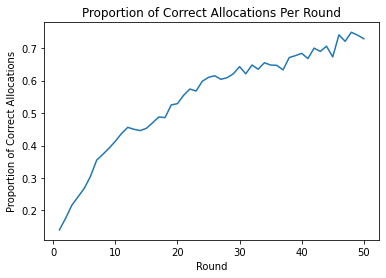

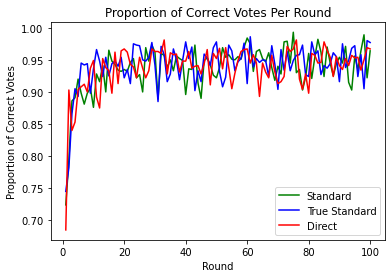

In [77]:
# Random graph simulation

n = 1000 # number of people
rand_truecomps = np.random.random_sample(size = n)
rand_nbpairs = construct_neighborpairs(n)
plot_allocation_performance(rand_truecomps, rand_nbpairs, rounds=50)
plot_vote_performance(rand_truecomps, rand_nbpairs, rounds=100)



In [ ]:
# TODO: grid structure